In [1]:
import requests
import pandas as pd
import json
import numpy as np


# Setup pitch and plot
from mplsoccer.pitch import Pitch ,VerticalPitch

username = "XXX"
password = "XXX"


from skillcorner.client import SkillcornerClient
client=SkillcornerClient(username=username,password=password)

def time_to_seconds(time_str):
    if time_str is None:
        return 90 * 60  # 120 minutes = 7200 seconds
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s


# black .


### Extract Tracking Data

In [2]:
####-----------------------------------------------------------------------------------
# If you're a skillcorner client and you know your match_id you can use the pyton client
###------------------------------------------------------------------------------------
# match_id=1886347
# client.save_match_tracking_data(match_id,
#                                 params={'data_version':3},
#                                 filepath=f'{match_id}_tracking_raw.jsonl')

####-----------------------------------------------------------------------------------
# If you've cloned the repo and are in your local copy
###------------------------------------------------------------------------------------
match_id = 1886347
# raw_data = pd.read_json(
#     f"../sample_data/{match_id}_tracking_extrapolated.jsonl", lines=True
# )

####-----------------------------------------------------------------------------------
# If you're on a separate project/environemnt
###------------------------------------------------------------------------------------

# # Construct the raw GitHub URL
tracking_data_github_url=f'https://media.githubusercontent.com/media/SkillCorner/opendata/741bdb798b0c1835057e3fa77244c1571a00e4aa/data/matches/{match_id}/{match_id}_tracking_extrapolated.jsonl' # Data is stored using GitLFS
raw_data=pd.read_json(tracking_data_github_url,lines=True)


raw_df = pd.json_normalize(
    raw_data.to_dict("records"),
    "player_data",
    ["frame", "timestamp", "period", "possession", "ball_data"],
)

# Extract 'player_id' and 'group from the 'possession' dictionary
raw_df["possession_player_id"] = raw_df["possession"].apply(
    lambda x: x.get("player_id")
)
raw_df["possession_group"] = raw_df["possession"].apply(lambda x: x.get("group"))


# (Optional) Expand the ball_data with json_normalize
raw_df[["ball_x", "ball_y", "ball_z", "is_detected_ball"]] = pd.json_normalize(
    raw_df.ball_data
)


# (Optional) Drop the original 'possession' column if you no longer need it
raw_df = raw_df.drop(columns=["possession", "ball_data"])

# Add the match_id identifier to your dataframe
raw_df["match_id"] = match_id
tracking_df = raw_df.copy()
tracking_df.head()

,x,y,player_id,is_detected,frame,timestamp,period,possession_player_id,possession_group,ball_x,ball_y,ball_z,is_detected_ball,match_id
0,-39.63,-0.08,51009,False,10,2025-10-26,1.0,NaN,None,0.32,0.38,0.13,True,1886347
1,-19.21,-9.18,176224,True,10,2025-10-26,1.0,NaN,None,0.32,0.38,0.13,True,1886347
2,-21.83,0.47,51649,True,10,2025-10-26,1.0,NaN,None,0.32,0.38,0.13,True,1886347
3,-1.16,-32.47,50983,True,10,2025-10-26,1.0,NaN,None,0.32,0.38,0.13,True,1886347
4,-18.88,15.73,735578,True,10,2025-10-26,1.0,NaN,None,0.32,0.38,0.13,True,1886347


### Extract MetaData

In [3]:
####-----------------------------------------------------------------------------------
# If you're a skillcorner client and you know your match_id you can use the python client
###------------------------------------------------------------------------------------
# match_id=1886347
# raw_match_data=client.get_match(match_id)


####-----------------------------------------------------------------------------------
# If you've cloned the repo and are in your local copy
###------------------------------------------------------------------------------------
# match_id = 1886347
# file_path = f"../../data/matches/{match_id}/{match_id}_match.json"

# with open(file_path, "r") as f:
#     raw_match_data = json.load(f)

####-----------------------------------------------------------------------------------
# If you're on a separate project/environemnt
###------------------------------------------------------------------------------------
match_id=1886347
meta_data_github_url=f'https://raw.githubusercontent.com/SkillCorner/opendata/741bdb798b0c1835057e3fa77244c1571a00e4aa/data/matches/{match_id}/{match_id}_match.json'
# Read the JSON data as a JSON object
response = requests.get(meta_data_github_url)
raw_match_data = response.json()


# The output has nested json elements. We process them
raw_match_df = pd.json_normalize(raw_match_data, max_level=2)
raw_match_df["home_team_side"] = raw_match_df["home_team_side"].astype(str)

players_df = pd.json_normalize(
    raw_match_df.to_dict("records"),
    record_path="players",
    meta=[
        "home_team_score",
        "away_team_score",
        "date_time",
        "home_team_side",
        "home_team.name",
        "home_team.id",
        "away_team.name",
        "away_team.id",
    ],  # data we keep
)


# Take only players who played and create their total time
players_df = players_df[
    ~((players_df.start_time.isna()) & (players_df.end_time.isna()))
]
players_df["total_time"] = players_df["end_time"].apply(time_to_seconds) - players_df[
    "start_time"
].apply(time_to_seconds)

# Create a flag for GK
players_df["is_gk"] = players_df["player_role.acronym"] == "GK"

# Add a flag if the given player is home or away
players_df["match_name"] = (
    players_df["home_team.name"] + " vs " + players_df["away_team.name"]
)


# Add a flag if the given player is home or away
players_df["home_away_player"] = np.where(
    players_df.team_id == players_df["home_team.id"], "Home", "Away"
)

# Create flag from player
players_df["team_name"] = np.where(
    players_df.team_id == players_df["home_team.id"],
    players_df["home_team.name"],
    players_df["away_team.name"],
)

# Figure out sides
players_df[["home_team_side_1st_half", "home_team_side_2nd_half"]] = (
    players_df["home_team_side"]
    .astype(str)
    .str.strip("[]")
    .str.replace("'", "")
    .str.split(", ", expand=True)
)
# Clean up sides
players_df["direction_player_1st_half"] = np.where(
    players_df.home_away_player == "Home",
    players_df.home_team_side_1st_half,
    players_df.home_team_side_2nd_half,
)
players_df["direction_player_2nd_half"] = np.where(
    players_df.home_away_player == "Home",
    players_df.home_team_side_2nd_half,
    players_df.home_team_side_1st_half,
)


# Clean up and keep the columns that we want to keep about

columns_to_keep = [
    "start_time",
    "end_time",
    "match_name",
    "date_time",
    "home_team.name",
    "away_team.name",
    "id",
    "short_name",
    "number",
    "team_id",
    "team_name",
    "player_role.position_group",
    "total_time",
    "player_role.name",
    "player_role.acronym",
    "is_gk",
    "direction_player_1st_half",
    "direction_player_2nd_half",
]
players_df = players_df[columns_to_keep]
players_df.head()

,start_time,end_time,match_name,date_time,home_team.name,away_team.name,id,short_name,number,team_id,team_name,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half
0,00:00:00,01:25:21,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,38673,G. May,10,4177,Auckland FC,Center Forward,5121,Center Forward,CF,False,right_to_left,left_to_right
1,00:00:00,None,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,51713,C. Elliott,17,4177,Auckland FC,Full Back,5400,Right Back,RB,False,right_to_left,left_to_right
2,00:00:00,01:16:37,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,50951,J. Brimmer,22,4177,Auckland FC,Center Forward,4597,Center Forward,CF,False,right_to_left,left_to_right
3,00:00:00,01:24:58,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,50978,C. Timmins,19,1805,Newcastle United Jets FC,Midfield,5098,Left Defensive Midfield,LDM,False,left_to_right,right_to_left
4,00:00:00,None,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,133498,F. De Vries,15,4177,Auckland FC,Full Back,5400,Left Back,LB,False,right_to_left,left_to_right


### Merge Dataframes

In [4]:
# Merging datasets
enriched_tracking_data = tracking_df.merge(
    players_df, left_on=["player_id"], right_on=["id"]
)
enriched_tracking_data.head()

,x,y,player_id,is_detected,frame,timestamp,period,possession_player_id,possession_group,ball_x,...,number,team_id,team_name,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half
0,-39.63,-0.08,51009,False,10,2025-10-26,1.0,NaN,None,0.32,...,1,1805,Newcastle United Jets FC,Other,5400,Goalkeeper,GK,True,left_to_right,right_to_left
1,-19.21,-9.18,176224,True,10,2025-10-26,1.0,NaN,None,0.32,...,4,1805,Newcastle United Jets FC,Central Defender,5400,Right Center Back,RCB,False,left_to_right,right_to_left
2,-21.83,0.47,51649,True,10,2025-10-26,1.0,NaN,None,0.32,...,15,1805,Newcastle United Jets FC,Central Defender,5400,Left Center Back,LCB,False,left_to_right,right_to_left
3,-1.16,-32.47,50983,True,10,2025-10-26,1.0,NaN,None,0.32,...,14,1805,Newcastle United Jets FC,Full Back,5400,Right Back,RB,False,left_to_right,right_to_left
4,-18.88,15.73,735578,True,10,2025-10-26,1.0,NaN,None,0.32,...,33,1805,Newcastle United Jets FC,Full Back,5400,Left Back,LB,False,left_to_right,right_to_left


### Get dynamic events data

In [6]:
match_id = 1886347
de_match = pd.read_csv(f"./sample_data/{match_id}_dynamic_events.csv")

In [9]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print(f"Total columns: {len(de_match.columns)}")
list(de_match.columns)

Total columns: 294


['event_id',
 'index',
 'match_id',
 'frame_start',
 'frame_end',
 'frame_physical_start',
 'time_start',
 'time_end',
 'minute_start',
 'second_start',
 'duration',
 'period',
 'attacking_side_id',
 'attacking_side',
 'event_type_id',
 'event_type',
 'event_subtype_id',
 'event_subtype',
 'player_id',
 'player_name',
 'player_position_id',
 'player_position',
 'player_in_possession_id',
 'player_in_possession_name',
 'player_in_possession_position_id',
 'player_in_possession_position',
 'team_id',
 'team_shortname',
 'x_start',
 'y_start',
 'channel_id_start',
 'channel_start',
 'third_id_start',
 'third_start',
 'penalty_area_start',
 'x_end',
 'y_end',
 'channel_id_end',
 'channel_end',
 'third_id_end',
 'third_end',
 'penalty_area_end',
 'associated_player_possession_event_id',
 'associated_player_possession_frame_start',
 'associated_player_possession_frame_end',
 'associated_player_possession_end_type_id',
 'associated_player_possession_end_type',
 'associated_off_ball_run_event_

In [21]:
de_match[['event_id', 'index', 'frame_start', 'frame_end', 'time_start', 'time_end', 'event_type','event_subtype', 'player_id', 'player_in_possession_id']].head(10)

,event_id,index,frame_start,frame_end,time_start,time_end,event_type,event_subtype,player_id,player_in_possession_id
0,8_0,0,28,28,00:01.8,00:01.8,player_possession,NaN,966120,NaN
1,8_1,1,48,58,00:03.8,00:04.8,player_possession,NaN,51649,NaN
2,7_0,2,48,53,00:03.8,00:04.3,passing_option,NaN,735574,51649.0
3,7_1,3,48,58,00:03.8,00:04.8,passing_option,NaN,735578,51649.0
4,9_0,4,56,58,00:02.4,00:04.8,on_ball_engagement,pressing,50951,51649.0
5,8_2,5,72,89,00:06.2,00:07.9,player_possession,NaN,735578,NaN
6,7_2,6,72,82,00:06.2,00:07.2,passing_option,NaN,50978,735578.0
7,7_3,7,72,89,00:06.2,00:07.9,passing_option,NaN,795507,735578.0
8,7_4,8,72,89,00:06.2,00:07.9,passing_option,NaN,966120,735578.0
9,7_5,9,73,89,00:06.3,00:07.9,passing_option,NaN,735573,735578.0


In [30]:
de_match[de_match['lead_to_goal']==True]

,event_id,index,match_id,frame_start,frame_end,frame_physical_start,time_start,time_end,minute_start,second_start,duration,period,attacking_side_id,attacking_side,event_type_id,event_type,event_subtype_id,event_subtype,player_id,player_name,player_position_id,player_position,player_in_possession_id,player_in_possession_name,player_in_possession_position_id,player_in_possession_position,team_id,team_shortname,x_start,y_start,channel_id_start,channel_start,third_id_start,third_start,penalty_area_start,x_end,y_end,channel_id_end,channel_end,third_id_end,third_end,penalty_area_end,associated_player_possession_event_id,associated_player_possession_frame_start,associated_player_possession_frame_end,associated_player_possession_end_type_id,associated_player_possession_end_type,associated_off_ball_run_event_id,associated_off_ball_run_subtype_id,associated_off_ball_run_subtype,game_state_id,game_state,team_score,opponent_team_score,phase_index,player_possession_phase_index,first_player_possession_in_team_possession,last_player_possession_in_team_possession,lead_to_different_phase,issued_from_different_phase,n_player_possessions_in_phase,team_possession_loss_in_phase,team_in_possession_phase_type_id,team_in_possession_phase_type,team_out_of_possession_phase_type_id,team_out_of_possession_phase_type,current_team_in_possession_next_phase_type_id,current_team_in_possession_next_phase_type,current_team_out_of_possession_next_phase_type_id,current_team_out_of_possession_next_phase_type,current_team_in_possession_previous_phase_type_id,current_team_in_possession_previous_phase_type,current_team_out_of_possession_previous_phase_type_id,current_team_out_of_possession_previous_phase_type,game_interruption_before_id,game_interruption_before,game_interruption_after_id,game_interruption_after,lead_to_shot,lead_to_goal,distance_covered,trajectory_angle,trajectory_direction_id,trajectory_direction,in_to_out,out_to_in,speed_avg,speed_avg_band_id,speed_avg_band,separation_start,separation_end,separation_gain,last_defensive_line_x_start,last_defensive_line_x_end,delta_to_last_defensive_line_start,delta_to_last_defensive_line_end,delta_to_last_defensive_line_gain,last_defensive_line_height_start,last_defensive_line_height_end,last_defensive_line_height_gain,inside_defensive_shape_start,inside_defensive_shape_end,start_type_id,start_type,end_type_id,end_type,consecutive_on_ball_engagements,one_touch,quick_pass,carry,forward_momentum,is_header,hand_pass,initiate_give_and_go,pass_angle_received,pass_direction_received_id,pass_direction_received,pass_distance_received,pass_range_received_id,pass_range_received,pass_outcome_id,pass_outcome,targeted_passing_option_event_id,high_pass,player_targeted_id,player_targeted_name,player_targeted_position_id,player_targeted_position,player_targeted_x_pass,player_targeted_y_pass,player_targeted_channel_pass_id,player_targeted_channel_pass,player_targeted_third_pass_id,player_targeted_third_pass,player_targeted_penalty_area_pass,player_targeted_x_reception,player_targeted_y_reception,player_targeted_channel_reception_id,player_targeted_channel_reception,player_targeted_third_reception_id,player_targeted_third_reception,player_targeted_penalty_area_reception,player_targeted_distance_to_goal_start,player_targeted_distance_to_goal_end,player_targeted_angle_to_goal_start,player_targeted_angle_to_goal_end,player_targeted_average_speed,player_targeted_speed_avg_band_id,player_targeted_speed_avg_band,speed_difference,player_targeted_xpass_completion,player_targeted_difficult_pass_target,player_targeted_xthreat,player_targeted_dangerous,n_passing_options,n_off_ball_runs,n_passing_options_line_break,n_passing_options_first_line_break,n_passing_options_second_last_line_break,n_passing_options_last_line_break,n_passing_options_ahead,n_passing_options_dangerous_difficult,n_passing_options_dangerous_not_difficult,n_passing_options_not_dangerous_not_difficult,n_passing_options_not_dangerous_difficult,n_passing_options_at_start,n_passi

In [11]:
specific_event = de_match[de_match.event_id == "1_2"][
    [
        "player_id",
        "frame_start",
        "frame_end",
        "event_type",
        "team_id",
        "player_in_possession_id",
        "x_start",
        "y_start",
        "x_end",
        "y_end",
    ]
]

synced = specific_event.merge(
    enriched_tracking_data,
    left_on=["frame_end"],
    right_on="frame",
    suffixes=("_event", "_tracking"),
)

synced["runner"] = synced.player_id_event == synced.player_id_tracking
synced["ball_carrier"] = synced.player_in_possession_id == synced.player_id_tracking
synced["tip"] = synced.team_id_event == synced.team_id_tracking

synced.head()

,player_id_event,frame_start,frame_end,event_type,team_id_event,player_in_possession_id,x_start,y_start,x_end,y_end,x,y,player_id_tracking,is_detected,frame,timestamp,period,possession_player_id,possession_group,ball_x,ball_y,ball_z,is_detected_ball,match_id,start_time,end_time,match_name,date_time,home_team.name,away_team.name,id,short_name,number,team_id_tracking,team_name,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half,runner,ball_carrier,tip
0,966120,82,99,off_ball_run,1805,735578.0,15.51,6.38,19.96,13.36,-41.11,4.64,51009,False,99,2025-10-26 00:00:08.900,1.0,NaN,away team,10.87,20.01,3.29,True,1886347,00:00:00,None,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,51009,R. Scott,1,1805,Newcastle United Jets FC,Other,5400,Goalkeeper,GK,True,left_to_right,right_to_left,False,False,True
1,966120,82,99,off_ball_run,1805,735578.0,15.51,6.38,19.96,13.36,-17.31,-2.80,176224,True,99,2025-10-26 00:00:08.900,1.0,NaN,away team,10.87,20.01,3.29,True,1886347,00:00:00,None,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,176224,P. Cancar,4,1805,Newcastle United Jets FC,Central Defender,5400,Right Center Back,RCB,False,left_to_right,right_to_left,False,False,True
2,966120,82,99,off_ball_run,1805,735578.0,15.51,6.38,19.96,13.36,-21.15,12.37,51649,True,99,2025-10-26 00:00:08.900,1.0,NaN,away team,10.87,20.01,3.29,True,1886347,00:00:00,None,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,51649,A. Šušnjar,15,1805,Newcastle United Jets FC,Central Defender,5400,Left Center Back,LCB,False,left_to_right,right_to_left,False,False,True
3,966120,82,99,off_ball_run,1805,735578.0,15.51,6.38,19.96,13.36,10.77,-25.83,50983,True,99,2025-10-26 00:00:08.900,1.0,NaN,away team,10.87,20.01,3.29,True,1886347,00:00:00,None,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,50983,D. Ingham,14,1805,Newcastle United Jets FC,Full Back,5400,Right Back,RB,False,left_to_right,right_to_left,False,False,True
4,966120,82,99,off_ball_run,1805,735578.0,15.51,6.38,19.96,13.36,-8.24,25.80,735578,True,99,2025-10-26 00:00:08.900,1.0,NaN,away team,10.87,20.01,3.29,True,1886347,00:00:00,None,Auckland FC vs Newcastle United Jets FC,2024-11-30T04:00:00Z,Auckland FC,Newcastle United Jets FC,735578,M. Natta,33,1805,Newcastle United Jets FC,Full Back,5400,Left Back,LB,False,left_to_right,right_to_left,False,True,True


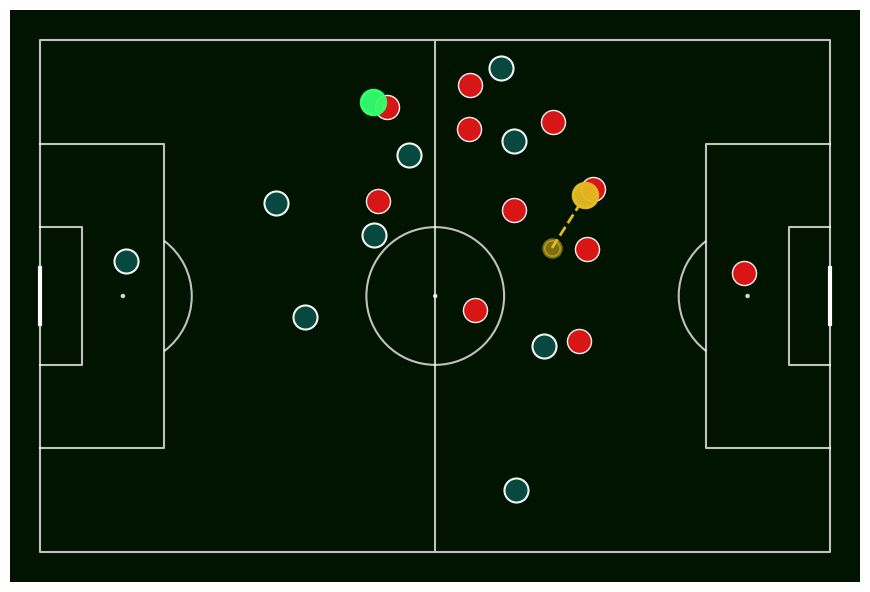

In [16]:
synced["runner"] = synced.player_id_event == synced.player_id_tracking
synced["ball_carrier"] = synced.player_in_possession_id == synced.player_id_tracking
synced["tip"] = synced.team_id_event == synced.team_id_tracking

pitch = Pitch(
    pitch_type="skillcorner",
    line_alpha=0.75,
    pitch_length=105,
    pitch_width=68,
    pitch_color="#001400",
    line_color="white",
    linewidth=1.5,
)
fig, ax = pitch.grid(figheight=8, endnote_height=0, title_height=0)

size = 300
possession_team = synced[synced.tip == True]
ax.scatter(
    possession_team["x"],
    possession_team["y"],
    c="#084D42",
    alpha=0.95,
    s=size,
    edgecolors="white",
    linewidths=1.5,
    zorder=10,
    label="team",
)

out_of_possession_team = synced[synced.tip == False]
ax.scatter(
    out_of_possession_team["x"],
    out_of_possession_team["y"],
    c="#E51717",
    alpha=0.95,
    s=size,
    edgecolors="white",
    linewidths=1,
    zorder=10,
    label="team",
)

runner = synced[synced.runner == True]
ax.scatter(
    runner["x"],
    runner["y"],
    c="#E5BA21",
    alpha=0.95,
    s=size,
    edgecolors="#E5BA21",
    linewidths=2.5,
    zorder=10,
    label="team",
)

# Running
ax.plot(
    [runner["x_start"], runner["x"]],
    [runner["y_start"], runner["y"]],
    color="#E5BA21",
    linewidth=2,
    ls="--",
)

ax.scatter(
    runner["x_start"],
    runner["y_start"],
    c="#E5BA21",
    alpha=0.55,
    s=size / 2,
    edgecolors="#E5BA21",
    linewidths=2.5,
    zorder=10,
    label="team",
)


ball_carrier = synced[synced.ball_carrier == True]
ax.scatter(
    ball_carrier["x"],
    ball_carrier["y"],
    c="#32FE6B",
    alpha=0.95,
    s=size,
    edgecolors="#32FE6B",
    linewidths=2.5,
    zorder=10,
    label="team",
)

### Plot

In [13]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

def plot_tracking_with_events_frame(enriched_data, events_data, frame_num, delay=0.1):
    """
    Plot a single frame of tracking data with event highlighting
    
    Parameters:
    - enriched_data: DataFrame with enriched tracking data
    - events_data: DataFrame with dynamic events data
    - frame_num: Frame number to plot
    - delay: Delay between frames (for animation effect)
    """
    # Filter tracking data for specific frame
    frame_data = enriched_data[enriched_data['frame'] == frame_num]
    
    if frame_data.empty:
        print(f"No tracking data found for frame {frame_num}")
        return
    
    # Check for events at this frame
    frame_events = events_data[
        (events_data['frame_start'] <= frame_num) & 
        (events_data['frame_end'] >= frame_num)
    ]
    
    # Create pitch
    pitch = Pitch(
        pitch_type="skillcorner",
        line_alpha=0.75,
        pitch_length=105,
        pitch_width=68,
        pitch_color="#001400",
        line_color="white",
        linewidth=1.5,
    )
    
    fig, ax = pitch.draw(figsize=(14, 10))
    
    size = 300
    
    # Default team colors
    teams = frame_data['team_name'].unique()
    team_colors = {'possession': '#084D42', 'out_of_possession': '#E51717'}
    
    # Plot regular players first
    for i, team in enumerate(teams):
        team_data = frame_data[frame_data['team_name'] == team]
        
        # Regular players
        regular_players = team_data[team_data['is_gk'] == False]
        ax.scatter(
            regular_players['x'],
            regular_players['y'],
            c='#084D42' if i == 0 else '#E51717',
            alpha=0.95,
            s=size,
            edgecolors='white',
            linewidths=1.5,
            zorder=10
        )
        
        # Goalkeepers
        goalkeepers = team_data[team_data['is_gk'] == True]
        if not goalkeepers.empty:
            ax.scatter(
                goalkeepers['x'],
                goalkeepers['y'],
                c='#084D42' if i == 0 else '#E51717',
                alpha=0.95,
                s=size * 1.2,
                edgecolors='yellow',
                linewidths=3,
                marker='s',
                zorder=10
            )
    
    # Plot ball
    if 'ball_x' in frame_data.columns and not frame_data['ball_x'].isna().all():
        ball_data = frame_data[['ball_x', 'ball_y']].dropna()
        if not ball_data.empty:
            ax.scatter(
                ball_data['ball_x'].iloc[0],
                ball_data['ball_y'].iloc[0],
                c='white',
                s=100,
                edgecolors='black',
                linewidths=2,
                zorder=15
            )
    
    # Highlight events if they exist at this frame
    event_info = []
    if not frame_events.empty:
        for _, event in frame_events.iterrows():
            # Merge event with tracking data for this frame
            event_tracking = frame_data.merge(
                pd.DataFrame([event]),
                left_on=['player_id'],
                right_on=['player_id'],
                how='inner'
            )
            
            if not event_tracking.empty:
                # Highlight the player involved in the event (runner/event player)
                runner_data = event_tracking[event_tracking['player_id'] == event['player_id']]
                if not runner_data.empty:
                    ax.scatter(
                        runner_data['x'],
                        runner_data['y'],
                        c='#E5BA21',  # Yellow for event player
                        alpha=0.95,
                        s=size * 1.3,
                        edgecolors='#E5BA21',
                        linewidths=3,
                        zorder=20
                    )
                    
                    # Draw trajectory line if we have start/end positions
                    if pd.notna(event['x_start']) and pd.notna(event['x_end']):
                        ax.plot(
                            [event['x_start'], event['x_end']],
                            [event['y_start'], event['y_end']],
                            color='#E5BA21',
                            linewidth=3,
                            ls='--',
                            alpha=0.8,
                            zorder=15
                        )
                        
                        # Mark start position
                        ax.scatter(
                            event['x_start'],
                            event['y_start'],
                            c='#E5BA21',
                            alpha=0.6,
                            s=size/2,
                            edgecolors='#E5BA21',
                            linewidths=2,
                            zorder=15
                        )
            
            # Highlight ball carrier if different from event player
            if pd.notna(event['player_in_possession_id']) and event['player_in_possession_id'] != event['player_id']:
                ball_carrier_data = frame_data[frame_data['player_id'] == event['player_in_possession_id']]
                if not ball_carrier_data.empty:
                    ax.scatter(
                        ball_carrier_data['x'],
                        ball_carrier_data['y'],
                        c='#32FE6B',  # Green for ball carrier
                        alpha=0.95,
                        s=size * 1.2,
                        edgecolors='#32FE6B',
                        linewidths=3,
                        zorder=20
                    )
            
            # Collect event info for display
            event_info.append(f"{event['event_type']} (ID: {event['event_id']})")
    
    # Add frame and event info
    timestamp = frame_data['timestamp'].iloc[0] if 'timestamp' in frame_data.columns else 'N/A'
    period = frame_data['period'].iloc[0] if 'period' in frame_data.columns else 'N/A'
    
    title = f'Frame: {frame_num} | Time: {timestamp} | Period: {period}'
    if event_info:
        title += f'\nEvents: {", ".join(event_info)}'
    
    ax.set_title(title, fontsize=12, fontweight='bold', color='white', pad=20)
    
    # Add legend
    legend_elements = [
        plt.scatter([], [], c='#084D42', s=100, label='Team 1'),
        plt.scatter([], [], c='#E51717', s=100, label='Team 2'),
        plt.scatter([], [], c='white', s=50, edgecolors='black', label='Ball'),
    ]
    
    if event_info:
        legend_elements.extend([
            plt.scatter([], [], c='#E5BA21', s=120, label='Event Player'),
            plt.scatter([], [], c='#32FE6B', s=120, label='Ball Carrier'),
        ])
    
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1))
    
    plt.tight_layout()
    plt.show()
    
    if delay > 0:
        time.sleep(delay)

def animate_tracking_with_events(enriched_data, events_data, start_frame=10, end_frame=100, delay=0.3):
    """
    Animate tracking data with event highlighting through multiple frames
    
    Parameters:
    - enriched_data: DataFrame with enriched tracking data
    - events_data: DataFrame with dynamic events data
    - start_frame: Starting frame number
    - end_frame: Ending frame number
    - delay: Delay between frames in seconds
    """
    available_frames = sorted(enriched_data['frame'].unique())
    frames_to_plot = [f for f in available_frames if start_frame <= f <= end_frame]
    
    # Check which frames have events
    event_frames = set()
    for _, event in events_data.iterrows():
        event_frames.update(range(int(event['frame_start']), int(event['frame_end']) + 1))
    
    frames_with_events = [f for f in frames_to_plot if f in event_frames]
    
    print(f"Animating {len(frames_to_plot)} frames from {start_frame} to {end_frame}")
    print(f"Frames with events: {len(frames_with_events)} out of {len(frames_to_plot)}")
    
    if frames_with_events:
        print("Event frames:", sorted(frames_with_events)[:10], "..." if len(frames_with_events) > 10 else "")
    
    for frame_num in frames_to_plot:
        clear_output(wait=True)
        plot_tracking_with_events_frame(enriched_data, events_data, frame_num, delay=0)
        if delay > 0:
            time.sleep(delay)

# Example usage:
# animate_tracking_with_events(enriched_tracking_data, de_match, start_frame=10, end_frame=100, delay=0.3)

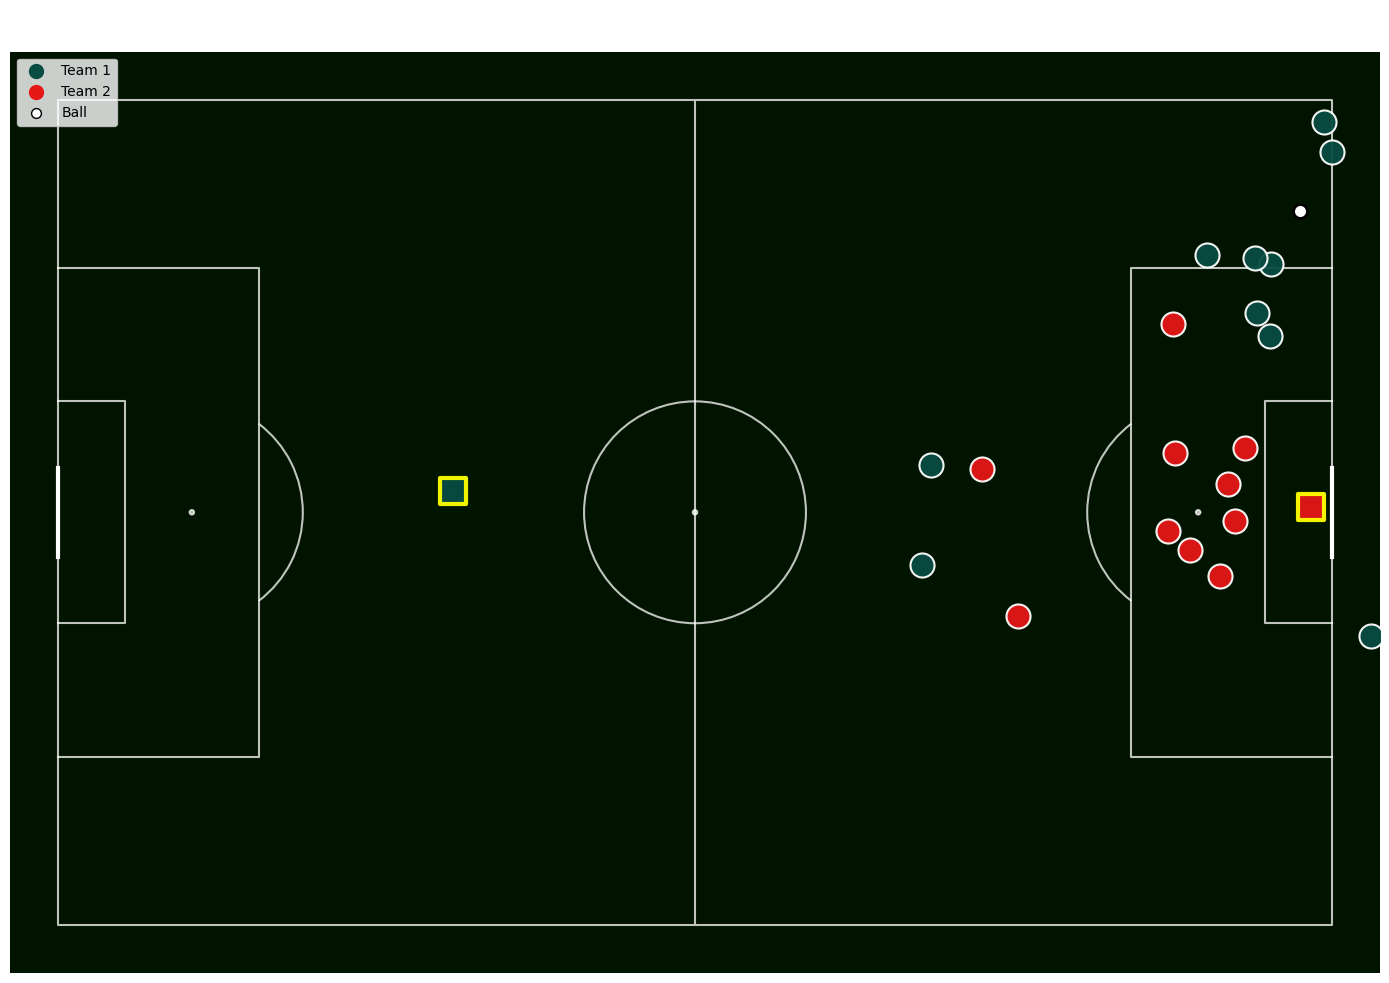

In [33]:
# Run the animation with events
animate_tracking_with_events(enriched_tracking_data, de_match, start_frame=50450, end_frame=50950, delay=0.001)